# Setup

This project requires Python 3.7 or above

In [1]:
import sys

assert sys.version_info >= (3, 7)

And Tensorflow >= 2.8:

In [5]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

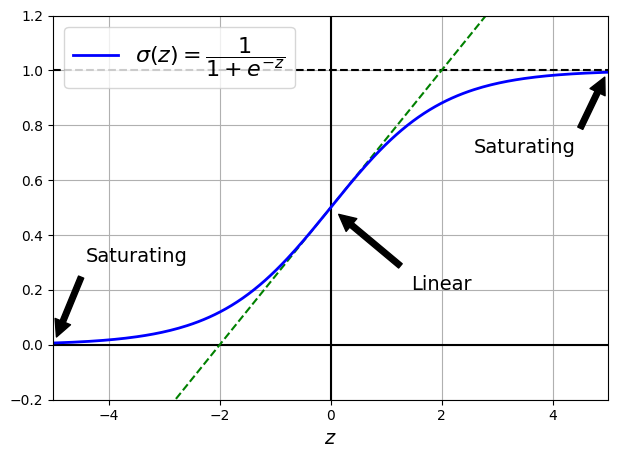

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
              fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leky ReLU

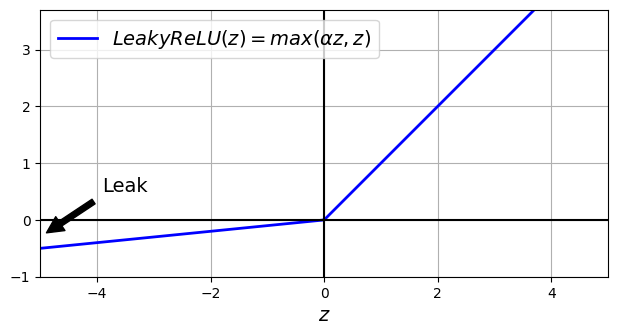

In [8]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), 'b-', linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

In [11]:
dense = tf.keras.layers.Dense(50, activation="elu", 
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparamaters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across the exploding/vanishing gradients problem:

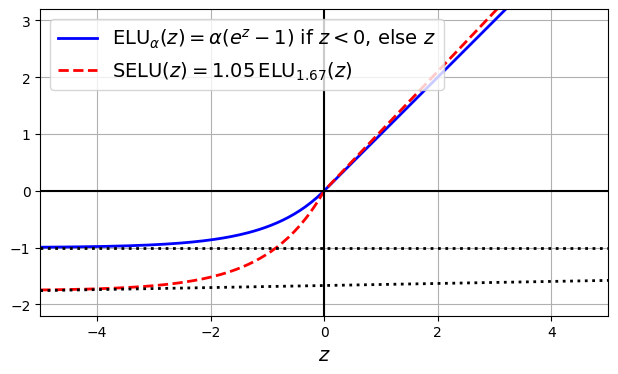

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper)
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k:", linewidth=2)
plt.plot([-5, 5], [-1.758, -1.578], "k:", linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()


In [13]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

__An example of a self-regularized network using SELU__

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Don't forget to scale the inputs to mean 0 and standard deviation 1

In [16]:
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

C:\Users\HP\AppData\Local\Temp\ipykernel_21088\2231411249.py:3: RuntimeWarning: invalid value encountered in divide
  X_train_scaled = (X_train - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_21088\2231411249.py:4: RuntimeWarning: invalid value encountered in divide
  X_valid_scaled = (X_valid - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_21088\2231411249.py:5: RuntimeWarning: divide by zero encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_21088\2231411249.py:5: RuntimeWarning: invalid value encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds


In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 46s 24ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 37s 21ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 31s 18ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead.

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 28s 15ms/step - loss: 2.0243 - accuracy: 0.1897 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.8120 - accuracy: 0.2794 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 27s 15ms/step - loss: 1.3095 - accuracy: 0.4844 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 27s 15ms/step - loss: 1.0295 - accuracy: 0.6376 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9199 - accuracy: 0.6968 - val_loss: nan - val_accuracy: 0.0978


Not great at all, we suffered from the vanishing/exploding gradient problem.

### GELU, Swish and Mish

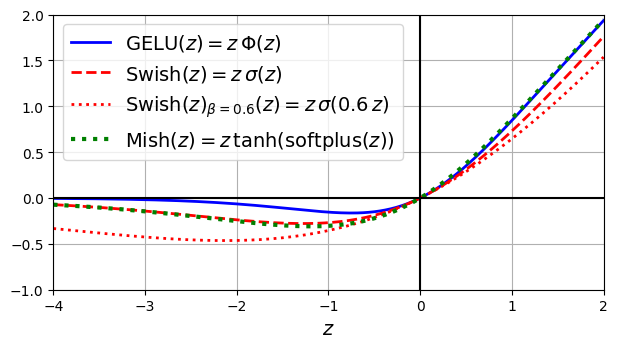

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$(z)_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], "k-")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

Batch normalizing algorithm

1. $\boldsymbol{\mu}_{B} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} \boldsymbol{x}^{(i)}$
2. $\boldsymbol{\sigma}_{B}^{2} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} ({\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}})^{2}$
3. $\hat{\boldsymbol{x}}^{(i)} = \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}}{\sqrt{{\boldsymbol{\sigma}_B^{2}}+{\epsilon}}}$
4. $\boldsymbol{z}^{(i)}=\boldsymbol{\gamma}\otimes{\hat{\boldsymbol{x}}^{(i)}} + \boldsymbol{\beta}$

In this algorithm:
- $\boldsymbol{\mu}_{B}$ is the vector of input means, evaluated over the whole mini-batch _B_ (it contains one mean per input).
- $m_B$ is the number of instances in the mini-batch.
- $\boldsymbol{\sigma}_{B}$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).
- $\hat{\boldsymbol{x}^{(i)}}$ is the vector of zero-centered and normalized inputs for instance _i_.
- $\epsilon$ is a tiny number that avoids division by zero and ensures the gradients don't grow too large (typically $10^{-5}$). This is called _smoothing term_.
- $\boldsymbol{\gamma}$ is the output scale parameter vector for the layer (each input is multiplied by its correcter per input).
- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).
- $\boldsymbol{\beta}$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.
- **z**<sup>(i)</sup> is the output of the BN operation. It is a rescaled and shifted version of the inputs. 

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3948 - accuracy: 0.8812 - val_loss: 0.1691 - val_accuracy: 0.9518
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2057 - accuracy: 0.9385 - val_loss: 0.1350 - val_accuracy: 0.9614


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4704 - accuracy: 0.8706 - val_loss: 0.1787 - val_accuracy: 0.9566
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2263 - accuracy: 0.9365 - val_loss: 0.1281 - val_accuracy: 0.9670


## Gradient Clipping

Technique to mitigate exploding gradients problem.

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [33]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [34]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
- `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try reusing it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [35]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1379/1379 [==============================] - 4s 2ms/step - loss: 1.5665 - accuracy: 0.5033 - val_loss: 0.9306 - val_accuracy: 0.7917
Epoch 2/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.7207 - accuracy: 0.8026 - val_loss: 0.4778 - val_accuracy: 0.8833
Epoch 3/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.4823 - accuracy: 0.8643 - val_loss: 0.3474 - val_accuracy: 0.9097
Epoch 4/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3903 - accuracy: 0.8879 - val_loss: 0.2918 - val_accuracy: 0.9231
Epoch 5/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3425 - accuracy: 0.9002 - val_loss: 0.2605 - val_accuracy: 0.9306
Epoch 6/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3124 - accuracy: 0.9081 - val_loss: 0.2407 - val_accuracy: 0.9328
Epoch 7/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.2913 - accuracy: 0.9136 - val_loss: 0.2284 - val_accuracy:

In [36]:
# train and evaluate model B, without using model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 45ms/step - loss: 0.6175 - accuracy: 0.5850 - val_loss: 0.6285 - val_accuracy: 0.6151
Epoch 2/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6025 - accuracy: 0.6350 - val_loss: 0.6164 - val_accuracy: 0.6446
Epoch 3/20
7/7 [==============================] - 0s 25ms/step - loss: 0.5897 - accuracy: 0.6950 - val_loss: 0.6042 - val_accuracy: 0.6925
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.5773 - accuracy: 0.7500 - val_loss: 0.5927 - val_accuracy: 0.7281
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5656 - accuracy: 0.7800 - val_loss: 0.5817 - val_accuracy: 0.7719
Epoch 6/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5541 - accuracy: 0.8000 - val_loss: 0.5704 - val_accuracy: 0.8198
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5427 - accuracy: 0.8350 - val_loss: 0.5592 - val_accuracy: 0.8513
Epoch 8/20
7/7 [===========

[0.45618051290512085, 0.9284294247627258]

Model B reaches 84.84% accuracy on the test set. Now let's try reusing the pretrained model A.

In [37]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a _clone_ of `model_A`:

In [38]:
tf.random.set_seed(42)

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

`tf.keras.models.clone_model()` only clones the architecture, not the weights. If you don't copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used. 

In [40]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights.

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Now, train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usualy a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4


7/7 [==============================] - 1s 45ms/step - loss: 0.6917 - accuracy: 0.6350 - val_loss: 0.5271 - val_accuracy: 0.6864
Epoch 2/4
7/7 [==============================] - 0s 25ms/step - loss: 0.5357 - accuracy: 0.7300 - val_loss: 0.4084 - val_accuracy: 0.8310
Epoch 3/4
7/7 [==============================] - 0s 24ms/step - loss: 0.4399 - accuracy: 0.8100 - val_loss: 0.3630 - val_accuracy: 0.8839
Epoch 4/4
7/7 [==============================] - 0s 29ms/step - loss: 0.4005 - accuracy: 0.8500 - val_loss: 0.3377 - val_accuracy: 0.9063
Epoch 1/16
7/7 [==============================] - 1s 52ms/step - loss: 0.3712 - accuracy: 0.8800 - val_loss: 0.3148 - val_accuracy: 0.9277
Epoch 2/16
7/7 [==============================] - 0s 26ms/step - loss: 0.3480 - accuracy: 0.9000 - val_loss: 0.2983 - val_accuracy: 0.9379
Epoch 3/16
7/7 [==============================] - 0s 25ms/step - loss: 0.3285 - accuracy: 0.9300 - val_loss: 0.2859 - val_accuracy: 0.9399
Epoch 4/16
7/7 [=========================

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.9657


[0.19507841765880585, 0.9657057523727417]

The model's accuracy went up 10 percentage points, from 84.84% to 93.98%

Training a deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using batch normalization, and reusing parts of a pretrained network (possibly built for an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. 

Popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and Adam and its variants

# Faster Optimizers

Gradient Descent algorithm:

$\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta{\Delta_{\boldsymbol\theta}}J(\boldsymbol\theta)$

In [44]:
# a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [46]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5558 - accuracy: 0.8413 - val_loss: 0.2235 - val_accuracy: 0.9362
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2497 - accuracy: 0.9274 - val_loss: 0.1718 - val_accuracy: 0.9478
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1948 - accuracy: 0.9435 - val_loss: 0.1458 - val_accuracy: 0.9552
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1622 - accuracy: 0.9526 - val_loss: 0.1226 - val_accuracy: 0.9646
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1376 - accuracy: 0.9601 - val_loss: 0.1147 - val_accuracy: 0.9686
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1206 - accuracy: 0.9652 - val_loss: 0.1052 - val_accuracy: 0.9710
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1071 - accuracy: 0.9682 - val_loss: 0.0978 - val_accuracy:

## Momentum optimization

Momentum algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_{\boldsymbol\theta}J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [47]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [48]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5583 - accuracy: 0.8397 - val_loss: 0.2178 - val_accuracy: 0.9408
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2507 - accuracy: 0.9275 - val_loss: 0.1719 - val_accuracy: 0.9530
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2006 - accuracy: 0.9423 - val_loss: 0.1501 - val_accuracy: 0.9556
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1694 - accuracy: 0.9507 - val_loss: 0.1266 - val_accuracy: 0.9650
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1455 - accuracy: 0.9569 - val_loss: 0.1186 - val_accuracy: 0.9664
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1289 - accuracy: 0.9619 - val_loss: 0.1038 - val_accuracy: 0.9714
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1149 - accuracy: 0.9660 - val_loss: 0.1014 - val_accuracy:

## Nesterov Accelerated Gradient

Nesterov accelerated gradient algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_\theta J(\boldsymbol\theta + \beta\boldsymbol{m})$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [50]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5510 - accuracy: 0.8413 - val_loss: 0.2266 - val_accuracy: 0.9406
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2542 - accuracy: 0.9261 - val_loss: 0.1810 - val_accuracy: 0.9510
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1989 - accuracy: 0.9416 - val_loss: 0.1523 - val_accuracy: 0.9566
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1650 - accuracy: 0.9520 - val_loss: 0.1287 - val_accuracy: 0.9654
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1402 - accuracy: 0.9591 - val_loss: 0.1183 - val_accuracy: 0.9680
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1226 - accuracy: 0.9643 - val_loss: 0.1070 - val_accuracy: 0.9718
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1077 - accuracy: 0.9684 - val_loss: 0.1000 - val_accuracy:

## AdaGrad

AdaGrad algorithm:

1. $\boldsymbol{s} \leftarrow \boldsymbol{s} + \Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

In [51]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [52]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2604 - accuracy: 0.6556 - val_loss: 0.5429 - val_accuracy: 0.8764
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5174 - accuracy: 0.8617 - val_loss: 0.3525 - val_accuracy: 0.9108
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4057 - accuracy: 0.8886 - val_loss: 0.2945 - val_accuracy: 0.9216
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3589 - accuracy: 0.9000 - val_loss: 0.2669 - val_accuracy: 0.9274
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3307 - accuracy: 0.9074 - val_loss: 0.2487 - val_accuracy: 0.9318
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3106 - accuracy: 0.9117 - val_loss: 0.2359 - val_accuracy: 0.9346
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2951 - accuracy: 0.9160 - val_loss: 0.2252 - val_accuracy:

## RMSProp

RMSProp algorithm

1. $\boldsymbol{s} \leftarrow \rho\boldsymbol{s} + (1-\rho)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

In [53]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [54]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2492 - accuracy: 0.9250 - val_loss: 0.1128 - val_accuracy: 0.9670
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1158 - accuracy: 0.9658 - val_loss: 0.1022 - val_accuracy: 0.9726
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0896 - accuracy: 0.9745 - val_loss: 0.1000 - val_accuracy: 0.9740
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0749 - accuracy: 0.9786 - val_loss: 0.0894 - val_accuracy: 0.9776
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0641 - accuracy: 0.9816 - val_loss: 0.1165 - val_accuracy: 0.9758
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0574 - accuracy: 0.9839 - val_loss: 0.1221 - val_accuracy: 0.9734
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0505 - accuracy: 0.9865 - val_loss: 0.1273 - val_accuracy:

## Adam Optimization

Adam(Adaptive moment estimation) algorithm:

1. $\boldsymbol{m} \leftarrow \beta_1\boldsymbol{m} - (1-\beta_1)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol{s} \leftarrow \beta_2\boldsymbol{\boldsymbol{s}} + (1-\beta_2)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
3. $\widehat{\boldsymbol{m}} \leftarrow \frac{\boldsymbol{m}}{1-{\beta_1}^t}$
4. $\widehat{\boldsymbol{s}} \leftarrow \frac{\boldsymbol{s}}{1-{\beta_2}^t}$
5. $\boldsymbol\theta \leftarrow \eta\widehat{\boldsymbol{m}}\oslash\sqrt{\widehat{\boldsymbol{s}}+\epsilon}$

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                    beta_2=0.999)

In [56]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2481 - accuracy: 0.9260 - val_loss: 0.1145 - val_accuracy: 0.9672
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1086 - accuracy: 0.9667 - val_loss: 0.0879 - val_accuracy: 0.9746
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0777 - accuracy: 0.9761 - val_loss: 0.0926 - val_accuracy: 0.9734
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0610 - accuracy: 0.9806 - val_loss: 0.0998 - val_accuracy: 0.9708
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0487 - accuracy: 0.9839 - val_loss: 0.1022 - val_accuracy: 0.9760
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0417 - accuracy: 0.9858 - val_loss: 0.1028 - val_accuracy: 0.9764
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0904 - val_accuracy:

### Adamax Optimization

In [57]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                        beta_2=0.999)

In [58]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3322 - accuracy: 0.9035 - val_loss: 0.1536 - val_accuracy: 0.9572
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1657 - accuracy: 0.9518 - val_loss: 0.1166 - val_accuracy: 0.9682
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1236 - accuracy: 0.9640 - val_loss: 0.0991 - val_accuracy: 0.9706
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0991 - accuracy: 0.9710 - val_loss: 0.0867 - val_accuracy: 0.9752
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0815 - accuracy: 0.9755 - val_loss: 0.0867 - val_accuracy: 0.9770
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0682 - accuracy: 0.9798 - val_loss: 0.0845 - val_accuracy: 0.9744
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0593 - accuracy: 0.9822 - val_loss: 0.0754 - val_accuracy:

### Nadam Optimzation

In [59]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [60]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2417 - accuracy: 0.9279 - val_loss: 0.1009 - val_accuracy: 0.9716
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1050 - accuracy: 0.9680 - val_loss: 0.0883 - val_accuracy: 0.9736
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.0814 - val_accuracy: 0.9764
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0602 - accuracy: 0.9809 - val_loss: 0.0846 - val_accuracy: 0.9732
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0496 - accuracy: 0.9836 - val_loss: 0.0832 - val_accuracy: 0.9766
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.0854 - val_accuracy: 0.9752
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0360 - accuracy: 0.9879 - val_loss: 0.0855 - val_accuracy:

### AdamW Optimization

In [61]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [62]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

c:\Users\HP\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\HP\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sur

In [63]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2594 - accuracy: 0.9212 - val_loss: 0.1205 - val_accuracy: 0.9642
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1098 - accuracy: 0.9669 - val_loss: 0.0925 - val_accuracy: 0.9702
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0798 - accuracy: 0.9755 - val_loss: 0.0803 - val_accuracy: 0.9754
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0634 - accuracy: 0.9801 - val_loss: 0.0935 - val_accuracy: 0.9730
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0507 - accuracy: 0.9840 - val_loss: 0.0695 - val_accuracy: 0.9800
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0422 - accuracy: 0.9863 - val_loss: 0.0894 - val_accuracy: 0.9774
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0373 - accuracy: 0.9879 - val_loss: 0.1073 - val_accuracy:

### Learning curves of all the optimizers

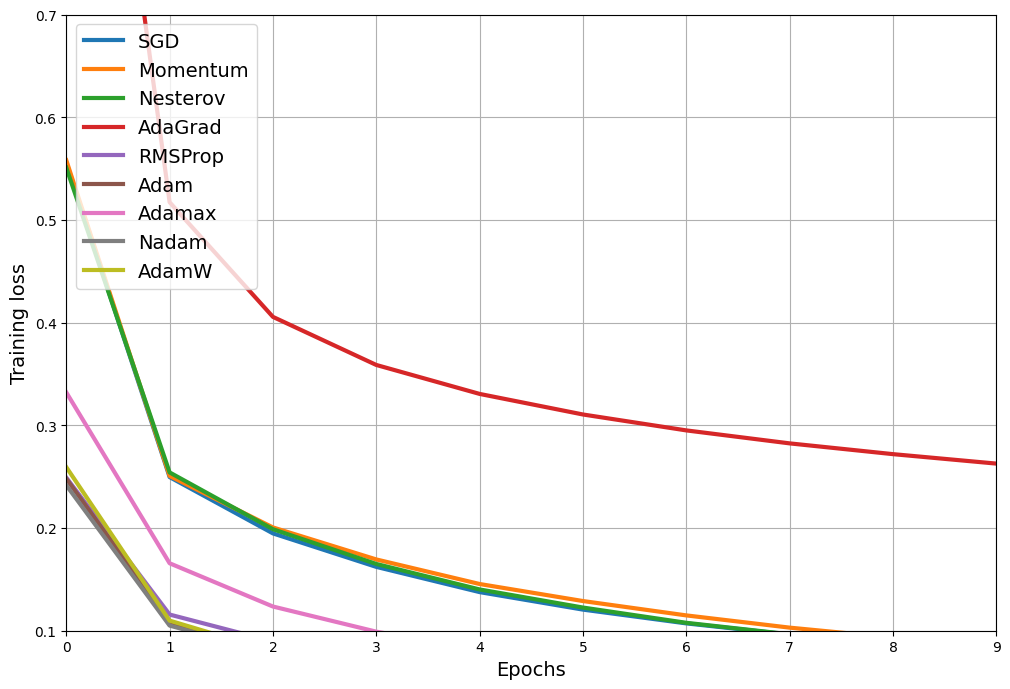

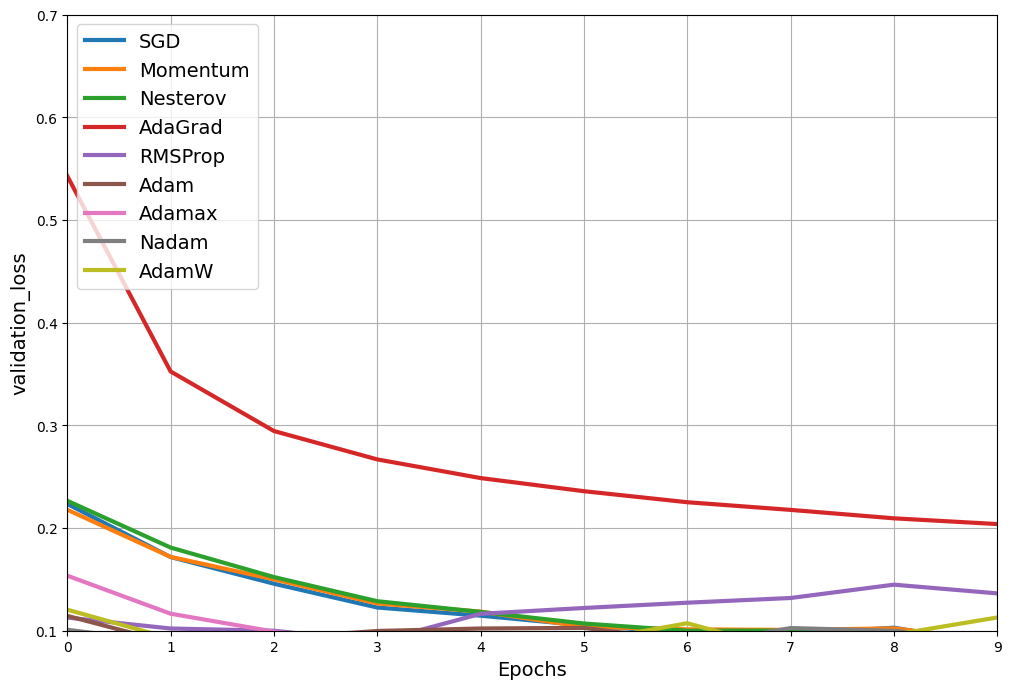

In [64]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                  opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)
    
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "validation_loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```

* Keras uses `c=1` and `s = 1 / decay`

In [65]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [66]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5732 - accuracy: 0.8368 - val_loss: 0.2386 - val_accuracy: 0.9338
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2560 - accuracy: 0.9258 - val_loss: 0.1876 - val_accuracy: 0.9498
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2037 - accuracy: 0.9407 - val_loss: 0.1554 - val_accuracy: 0.9590
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1744 - accuracy: 0.9489 - val_loss: 0.1355 - val_accuracy: 0.9642
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1548 - accuracy: 0.9546 - val_loss: 0.1261 - val_accuracy: 0.9668
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1410 - accuracy: 0.9590 - val_loss: 0.1211 - val_accuracy: 0.9674
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1295 - accuracy: 0.9620 - val_loss: 0.1139 - val_accuracy:

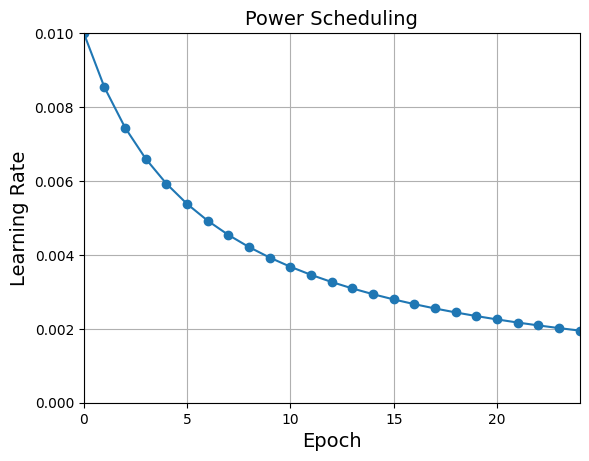

In [67]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [68]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [69]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s = 20)

In [70]:
# build and compile a model for fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [71]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5927 - accuracy: 0.8309 - val_loss: 0.2214 - val_accuracy: 0.9410 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2543 - accuracy: 0.9256 - val_loss: 0.1739 - val_accuracy: 0.9528 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2019 - accuracy: 0.9405 - val_loss: 0.1445 - val_accuracy: 0.9606 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1712 - accuracy: 0.9500 - val_loss: 0.1327 - val_accuracy: 0.9652 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1501 - accuracy: 0.9566 - val_loss: 0.1178 - val_accuracy: 0.9694 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1361 - accuracy: 0.9604 - val_loss: 0.1168 - val_accuracy: 0.9666 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 4s

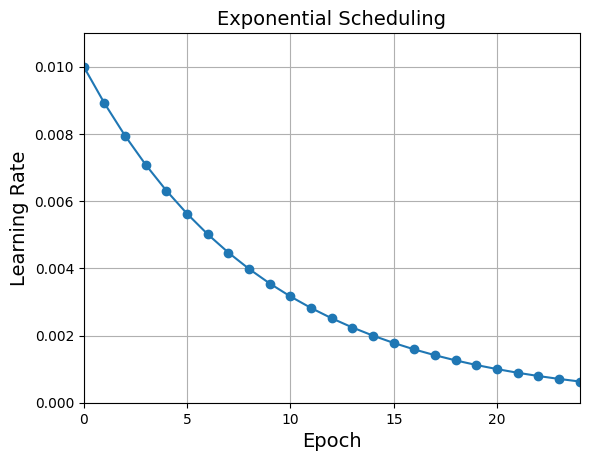

In [72]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [73]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [74]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [75]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [77]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2654 - accuracy: 0.9241 - val_loss: 0.1792 - val_accuracy: 0.9512 - lr: 0.0083
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2107 - accuracy: 0.9392 - val_loss: 0.1610 - val_accuracy: 0.9564 - lr: 0.0076
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1768 - accuracy: 0.9493 - val_loss: 0.1363 - val_accuracy: 0.9608 - lr: 0.0069
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1547 - accuracy: 0.9554 - val_loss: 0.1281 - val_accuracy: 0.9632 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1385 - accuracy: 0.9600 - val_loss: 0.1182 - val_accuracy: 0.9654 - lr: 0.0058
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1265 - accuracy: 0.9634 - val_loss: 0.1186 - val_accuracy: 0.9662 - lr: 0.0052
Epoch 7/25
1719/1719 [==============================] - 10

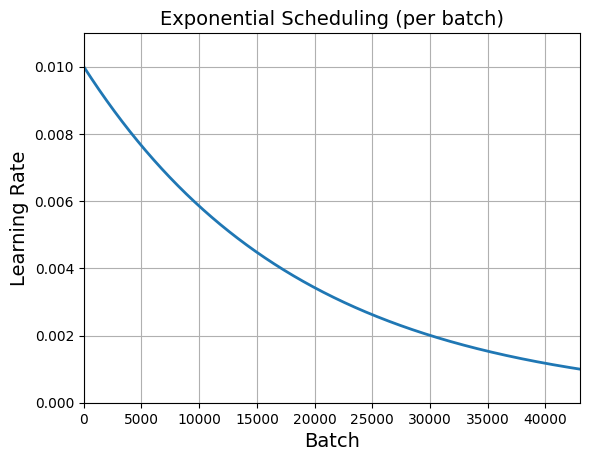

In [78]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [79]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [80]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [81]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3095 - accuracy: 0.9105 - val_loss: 0.1762 - val_accuracy: 0.9504 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2083 - accuracy: 0.9453 - val_loss: 0.1565 - val_accuracy: 0.9570 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1779 - accuracy: 0.9540 - val_loss: 0.1326 - val_accuracy: 0.9662 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1663 - accuracy: 0.9582 - val_loss: 0.1348 - val_accuracy: 0.9652 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1535 - accuracy: 0.9621 - val_loss: 0.1320 - val_accuracy: 0.9676 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0916 - accuracy: 0.9758 - val_loss: 0.1088 - val_accuracy: 0.9726 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] -

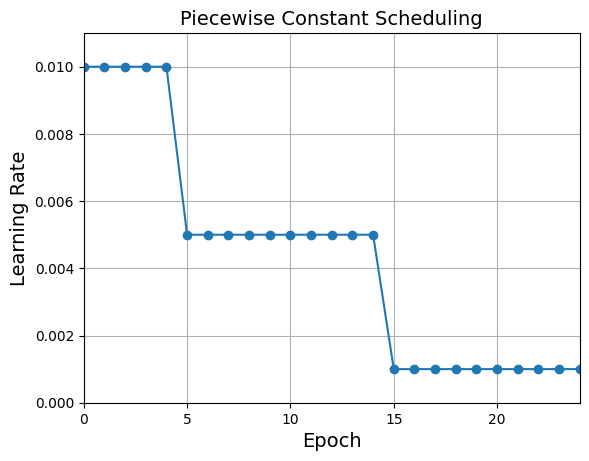

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [83]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [84]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5720 - accuracy: 0.8377 - val_loss: 0.2283 - val_accuracy: 0.9364 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2544 - accuracy: 0.9255 - val_loss: 0.1817 - val_accuracy: 0.9478 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2001 - accuracy: 0.9416 - val_loss: 0.1465 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1665 - accuracy: 0.9514 - val_loss: 0.1327 - val_accuracy: 0.9658 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1430 - accuracy: 0.9577 - val_loss: 0.1170 - val_accuracy: 0.9700 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1257 - accuracy: 0.9636 - val_loss: 0.1176 - val_accuracy: 0.9686 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 8s

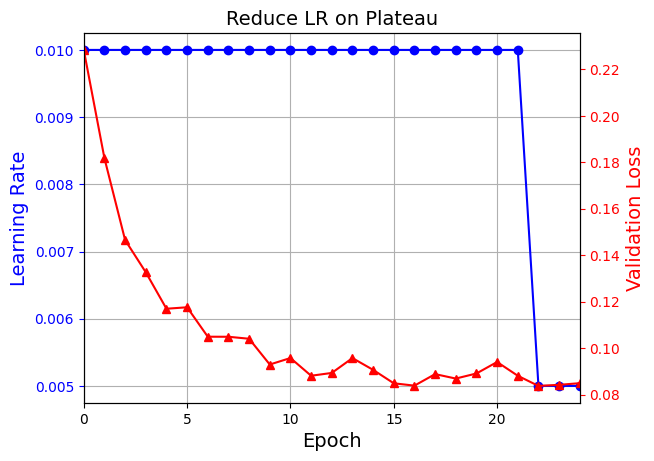

In [85]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation Loss", color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [86]:
import math

batch_size = 42
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [87]:
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5354 - accuracy: 0.8465 - val_loss: 0.2214 - val_accuracy: 0.9426
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2566 - accuracy: 0.9238 - val_loss: 0.1760 - val_accuracy: 0.9508
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2077 - accuracy: 0.9389 - val_loss: 0.1459 - val_accuracy: 0.9612
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1783 - accuracy: 0.9482 - val_loss: 0.1367 - val_accuracy: 0.9640
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1585 - accuracy: 0.9542 - val_loss: 0.1253 - val_accuracy: 0.9668
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1441 - accuracy: 0.9580 - val_loss: 0.1199 - val_accuracy: 0.9658
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1324 - accuracy: 0.9619 - val_loss: 0.1117 - val_accuracy:

In [88]:
# shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001]
)

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [27]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizers to their initial state.

In [28]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use the maximum learning rate in 1cycle is near the bottom of the curve.

In [29]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it

In [92]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 4ms/step - loss: 1.6899 - accuracy: 0.4203


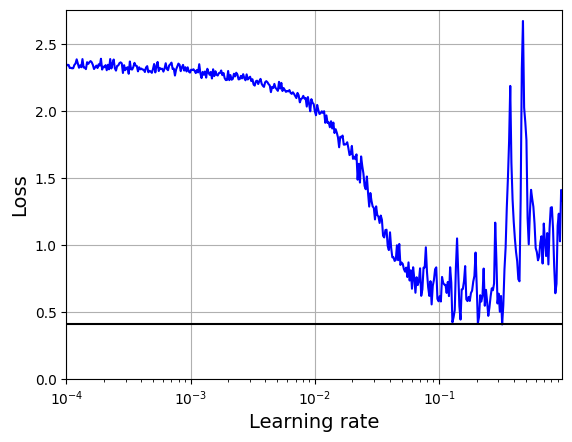

In [93]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning_rate to use for 1cycle is around 10<sup>-1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [94]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [95]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.9519 - accuracy: 0.7333 - val_loss: 0.3443 - val_accuracy: 0.9154
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3448 - accuracy: 0.9011 - val_loss: 0.2398 - val_accuracy: 0.9346
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.2605 - accuracy: 0.9240 - val_loss: 0.1862 - val_accuracy: 0.9484
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.2126 - accuracy: 0.9383 - val_loss: 0.1563 - val_accuracy: 0.9566
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1762 - accuracy: 0.9480 - val_loss: 0.1290 - val_accuracy: 0.9656
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1498 - accuracy: 0.9553 - val_loss: 0.1493 - val_accuracy: 0.9566
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.1301 - accuracy: 0.9615 - val_loss: 0.1264 - val_accuracy: 0.9636
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [96]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for $\ell_1$ regulariztion factor of 0.1 or `l1_l2(0.1, 0.01)` for both $\ell_1$ and $\ell_2$ regularization, with factors 0.1 and 0.01 respectively.

In [97]:
tf.random.set_seed(42)

In [98]:
from functools import partial

RegularizeDense = partial(tf.keras.layers.Dense,
                          activation="relu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizeDense(100),
    RegularizeDense(100),
    RegularizeDense(10, activation="softmax")
])

In [99]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 3.0451 - accuracy: 0.8625 - val_loss: 1.7059 - val_accuracy: 0.9320
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3279 - accuracy: 0.9056 - val_loss: 0.9789 - val_accuracy: 0.9298


## Dropout

In [100]:
tf.random.set_seed(42)

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [102]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4469 - accuracy: 0.8613 - val_loss: 0.1353 - val_accuracy: 0.9630
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2497 - accuracy: 0.9239 - val_loss: 0.1008 - val_accuracy: 0.9728
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2077 - accuracy: 0.9367 - val_loss: 0.0874 - val_accuracy: 0.9728
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1823 - accuracy: 0.9446 - val_loss: 0.0833 - val_accuracy: 0.9754
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1681 - accuracy: 0.9476 - val_loss: 0.0792 - val_accuracy: 0.9780
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1581 - accuracy: 0.9516 - val_loss: 0.0711 - val_accuracy: 0.9800
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1473 - accuracy: 0.9543 - val_loss: 0.0747 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy.

In [113]:
model.evaluate(X_train, y_train)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [109]:
model.evaluate(X_test, y_test)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [110]:
tf.random.set_seed(42)

In [111]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Averaging over multiple predictions with dropout turned one gives us a Monte Carlo estimate that is generally more reliable than a single prediction with dropout turned off.

In [ ]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 52ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.999, 0.   ,
       0.   ], dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.002, 0.003, 0.   , 0.   , 0.   , 0.004, 0.   ,
       0.001], dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.9777

In [ ]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [ ]:
# how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [ ]:
mc_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_111 (Dense)           (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_112 (Dense)           (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_113 (Dense)           (None, 10)              

Now we can use the model with MC Dropout:

In [ ]:
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 32ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

## Max norm

In [114]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [116]:
# how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Excercises

## 1. to 7.

1. Glorot Initialization and He initialization aims to fix the problem of vanishing/exploding gradients in the case of training deep neural network. These were designed to make the output standard deviation close as possible to the input standard deviation, at least at the beginning of training.
2. No, all weights must be set independent of the others, setting all the weights equal will make backpropagation fail not work properly. (**answer from the book**: all weights should be sampled indepently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same value, this symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.)
3. It is fine to initialize the bias terms to zero.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between -1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g, for binary classification), but it is rarely used in the hidden layers. The softplus activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely used in hidden layers.
5. If `momentum` hyperparameter is set too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed. Also when it is near minimum, it will overshoot. Then it will slow down and come back, overshoot again, and so on.
6. To get a sparse model, we can set the small weights to zero, we can use $\ell_1$ regularization during training, or we can use the TensorFlow Model Optimization Toolkit.
7. Dropout slows down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a. Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this excercise). Use He initialization and the Swish activation function function.

In [6]:
tf.random.set_seed(42)

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="swish",
                                    kernel_initializer="he_normal"))
                

### b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 * 32-pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for right learning rate each time you change the model's architecture or hyperparameters. 

**Note**: I have been unable to check for the optimal learning rate till now, so I used the learning rate which was mentioned in the solution.

In [11]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_valid, y_valid = X_train_full[:5000], y_train_full[:5000]
# X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [12]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog",
            "frog", "horse", "ship", "truck"]

In [10]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, metrics="accuracy")

In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                    restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                        save_best_only=True)
run_index = 1  # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard()
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 43s 26ms/step - loss: 4.0308 - accuracy: 0.1645 - val_loss: 2.1611 - val_accuracy: 0.2228
Epoch 2/100
1407/1407 [==============================] - 29s 20ms/step - loss: 2.0548 - accuracy: 0.2437 - val_loss: 2.0996 - val_accuracy: 0.2248
Epoch 3/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.9488 - accuracy: 0.2823 - val_loss: 1.9614 - val_accuracy: 0.3006
Epoch 4/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.8648 - accuracy: 0.3195 - val_loss: 1.8958 - val_accuracy: 0.3246
Epoch 5/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.7994 - accuracy: 0.3472 - val_loss: 1.8003 - val_accuracy: 0.3462
Epoch 6/100
1407/1407 [==============================] - 29s 20ms/step - loss: 1.7482 - accuracy: 0.3656 - val_loss: 1.7597 - val_accuracy: 0.3638
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.7067 - accuracy: 0.3850 - val_loss: 1

In [13]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4783 - accuracy: 0.4954


[1.4783128499984741, 0.49540001153945923]

### c. Now try adding batch normalization and compare the learning curves: is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [16]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, metrics="accuracy")

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increase every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 74s 52ms/step - loss: 1.0831 - accuracy: 0.6181 - val_loss: 1.5233 - val_accuracy: 0.4952
Epoch 2/100
1407/1407 [==============================] - 51s 36ms/step - loss: 1.0685 - accuracy: 0.6234 - val_loss: 1.5244 - val_accuracy: 0.4894
Epoch 3/100
1407/1407 [==============================] - 62s 44ms/step - loss: 1.0560 - accuracy: 0.6285 - val_loss: 1.5420 - val_accuracy: 0.4856
Epoch 4/100
1407/1407 [==============================] - 70s 50ms/step - loss: 1.0440 - accuracy: 0.6322 - val_loss: 1.5097 - val_accuracy: 0.4856
Epoch 5/100
1407/1407 [==============================] - 65s 46ms/step - loss: 1.0282 - accuracy: 0.6382 - val_loss: 1.4393 - val_accuracy: 0.5168
Epoch 6/100
1407/1407 [==============================] - 67s 48ms/step - loss: 1.0130 - accuracy: 0.6425 - val_loss: 1.5301 - val_accuracy: 0.4784
Epoch 7/100
1407/1407 [==============================] - 75s 53ms/step - loss: 1.0003 - accuracy: 0.6482 - val_loss: 1

In [19]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 3s 15ms/step - loss: 1.4393 - accuracy: 0.5168


[1.4393150806427002, 0.5167999863624573]

* When batch normalization was implemented after activation function it took 60 mins to train whereas the training without batch normalization took 25 mins. In the case where batch normalization was applied before activation function it took 24 mins whereas without batch normalization, training took 27 mins.

* Batch Normalization (after activation function) increases the accuracy on validation set from 46.58% to 51.52%.
In the case of batch normalization before activation function, accuracy on validation set increased from 49.54% to 51.68%

* Training an epoch takes twice the time when batch normalization is implemented but the this is counterbalanced by the fact that the model trains for lesser epochs to reach optimum.

### d. Try replacing batch normalization with SELU, and make the necessay adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normalization, make sure the DNN contains only a sequence of dense layers, etc.)

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [28]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [29]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [30]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_selu_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]


In [31]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 69s 42ms/step - loss: 1.9213 - accuracy: 0.3120 - val_loss: 1.8072 - val_accuracy: 0.3630
Epoch 2/100
1407/1407 [==============================] - 57s 41ms/step - loss: 1.7112 - accuracy: 0.3918 - val_loss: 1.6828 - val_accuracy: 0.4062
Epoch 3/100
1407/1407 [==============================] - 54s 38ms/step - loss: 1.6151 - accuracy: 0.4297 - val_loss: 1.6337 - val_accuracy: 0.4116
Epoch 4/100
1407/1407 [==============================] - 58s 41ms/step - loss: 1.5441 - accuracy: 0.4562 - val_loss: 1.6251 - val_accuracy: 0.4382
Epoch 5/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.4859 - accuracy: 0.4788 - val_loss: 1.6339 - val_accuracy: 0.4350
Epoch 6/100
1407/1407 [==============================] - 56s 40ms/step - loss: 1.4415 - accuracy: 0.4941 - val_loss: 1.5252 - val_accuracy: 0.4594
Epoch 7/100
1407/1407 [==============================] - 50s 35ms/step - loss: 1.3968 - accuracy: 0.5094 - val_loss: 1

In [32]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4832 - accuracy: 0.4940


[1.4831706285476685, 0.49399998784065247]

### e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [7]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [8]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increase every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [13]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [14]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 33s 20ms/step - loss: 1.8840 - accuracy: 0.3303 - val_loss: 1.7662 - val_accuracy: 0.3870
Epoch 2/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6542 - accuracy: 0.4159 - val_loss: 1.7209 - val_accuracy: 0.3888
Epoch 3/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5615 - accuracy: 0.4509 - val_loss: 1.6230 - val_accuracy: 0.4296
Epoch 4/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.4959 - accuracy: 0.4756 - val_loss: 1.5733 - val_accuracy: 0.4480
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4364 - accuracy: 0.4967 - val_loss: 1.5941 - val_accuracy: 0.4662
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.3906 - accuracy: 0.5164 - val_loss: 1.5014 - val_accuracy: 0.4780
Epoch 7/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3456 - accuracy: 0.5285 - val_loss: 1

In [15]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4714 - accuracy: 0.5110


[1.4714148044586182, 0.5109999775886536]

The model achieves almost the same accuracy as the model without `Alpha Dropout`

Use MC Dropout now.

In [16]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

In [22]:
import numpy as np

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

In [23]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

157/157 [==============================] - 1s 4ms/step


0.5134

### f. Retrain the model using 1cycle scheduling and see if it improves training speed and model accuracy

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [25]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [26]:
optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_loss",
            optimizer=optimizer,
            metrics=["accuracy"])

In [34]:
import math

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])